In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt


"""Load Directory for Dataset"""
from google.colab import drive
drive.mount('/content/drive')
data_path = '/content/drive/MyDrive/COMP3359_Project/archive/Garbage classification/Garbage classification'


Mounted at /content/drive


In [ ]:
""" Load Dataset and Preprocess Data """

batch_size = 32
train = tf.keras.preprocessing.image.ImageDataGenerator(
                        horizontal_flip=True, 
                        vertical_flip=True,
                        validation_split=0.2,
                        rescale=1./255,
                        shear_range = 0.1,
                        zoom_range = 0.1,
                        width_shift_range = 0.1,
                        height_shift_range = 0.1,
)

val = tf.keras.preprocessing.image.ImageDataGenerator(
                        rescale=1./255, 
                        validation_split=0.1
)

test = tf.keras.preprocessing.image.ImageDataGenerator(
                        rescale=1./255, 
                        validation_split=0.1
)



train_generator = train.flow_from_directory(
                        data_path,
                        target_size=(512,384),
                        batch_size=batch_size,
                        class_mode='categorical',
                        subset='training'
)

val_generator = val.flow_from_directory(
                        data_path,
                        target_size=(512,384),
                        batch_size=batch_size,
                        class_mode='categorical',
                        subset='validation' 
)

test_generator = test.flow_from_directory(
                        data_path,
                        target_size=(512,384),
                        batch_size=batch_size,
                        class_mode='categorical',
                        subset='validation' 
)

labels = (train_generator.class_indices)
labels = dict((v,k) for k,v in labels.items())
print(labels)

Found 2024 images belonging to 6 classes.
Found 251 images belonging to 6 classes.
Found 251 images belonging to 6 classes.
{0: 'cardboard', 1: 'glass', 2: 'metal', 3: 'paper', 4: 'plastic', 5: 'trash'}


In [ ]:
""" To Load the saved model """

# model = tf.keras.models.load_model('/content/drive/MyDrive/COMP3359_FinalWork/FW_InceRes3')
# history = model

' To Load the saved model '

In [ ]:
"""Build Inception Module"""
def inception_block(layer_in, f1, f1_in, f1_out, f2_in, f2_out, f3_out):
  layer_in = tf.keras.layers.Activation('relu')(layer_in)
  # inception1 = 1x1 conv, 3x3 conv, 3x3 conv
  inception1 = tf.keras.layers.Conv2D(f1, (1,1), padding='same', activation='relu')(layer_in)
  inception1 = tf.keras.layers.Conv2D(f1_in, (3,3), strides=(1,1), padding='same', activation='relu')(inception1)
  inception1 = tf.keras.layers.Conv2D(f1_out, (3,3), strides=(1,1), padding='same', activation='relu')(inception1)
  # inception2 = 1x1 conv, 3x3 conv
  inception2 = tf.keras.layers.Conv2D(f2_in, (1,1), padding='same', activation='relu')(layer_in)
  inception2 = tf.keras.layers.Conv2D(f2_out, (3,3), strides=(1,1), padding='same', activation='relu')(inception2)
  # pool = 3x3 max pooling, 1x1 conv
  pool = tf.keras.layers.MaxPooling2D((3,3), strides=(1,1), padding='same')(layer_in)
  pool = tf.keras.layers.Conv2D(f3_out, (1,1), padding='same', activation='relu')(pool)
  # concatenate 
  inception_out = tf.keras.layers.concatenate([inception1, inception2, pool], axis=-1)
  inception_out = tf.keras.layers.Conv2D(layer_in.get_shape()[-1], (1,1), padding='same')(inception_out)
  # residual identity
  residual_out = tf.keras.layers.Add()([inception_out, layer_in])
  layer_out = tf.keras.layers.Activation('relu')(residual_out)
 
  return layer_out



In [ ]:
num_classes = 6
input_image = tf.keras.layers.Input(shape=(512,384, 3))

layer1 = tf.keras.layers.Conv2D(32,(3,3), padding='same', activation='relu')(input_image)
layer2 = tf.keras.layers.Conv2D(32,(3,3), padding='same', activation='relu')(layer1)
layer3 = tf.keras.layers.MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='valid')(layer2)

block1 = inception_block(layer3, 32,48,64,32,32,32)
block2 = inception_block(block1, 32,48,64,32,32,32)
block3 = inception_block(block2, 32,48,64,32,32,32)
block4 = inception_block(block3, 32,48,64,32,32,32)

layer4 = tf.keras.layers.AvgPool2D((8,8))(block2)
layer5 = tf.keras.layers.Flatten()(layer4)
layer6 = tf.keras.layers.Dropout(0.5)(layer5)
layer7 = tf.keras.layers.Dense(num_classes,activation='softmax')(layer6)

model = tf.keras.Model(inputs=input_image, outputs=layer7)




In [ ]:
"""Compile model"""

opt = tf.keras.optimizers.Adam(learning_rate=1e-4)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()

# tf.keras.utils.plot_model(model, show_shapes=True, to_file='inception_model.png')

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 512, 384, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 512, 384, 32) 896         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 512, 384, 32) 9248        conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 256, 192, 32) 0           conv2d_1[0][0]                   
______________________________________________________________________________________________

In [ ]:
""" Train model """

# batch_size = 32
num_epochs = 50
step_size_train = train_generator.n//train_generator.batch_size
step_size_val= val_generator.n//val_generator.batch_size

history = model.fit(
                train_generator, 
                epochs = num_epochs, 
                steps_per_epoch = step_size_train,
                validation_data = val_generator, 
                validation_steps = step_size_val,
)


Epoch 1/50
63/63 [==============================] - 795s 12s/step - loss: 1.6480 - accuracy: 0.2886 - val_loss: 1.4634 - val_accuracy: 0.3482
Epoch 2/50
63/63 [==============================] - 89s 1s/step - loss: 1.3676 - accuracy: 0.4331 - val_loss: 1.4335 - val_accuracy: 0.4196
Epoch 3/50
63/63 [==============================] - 90s 1s/step - loss: 1.2984 - accuracy: 0.4868 - val_loss: 1.5141 - val_accuracy: 0.3884
Epoch 4/50
63/63 [==============================] - 89s 1s/step - loss: 1.2412 - accuracy: 0.5027 - val_loss: 1.4394 - val_accuracy: 0.4375
Epoch 5/50
63/63 [==============================] - 91s 1s/step - loss: 1.1897 - accuracy: 0.5211 - val_loss: 1.3590 - val_accuracy: 0.5491
Epoch 6/50
63/63 [==============================] - 88s 1s/step - loss: 1.1600 - accuracy: 0.5579 - val_loss: 1.2729 - val_accuracy: 0.5580
Epoch 7/50
63/63 [==============================] - 88s 1s/step - loss: 1.0375 - accuracy: 0.6022 - val_loss: 1.2232 - val_accuracy: 0.4955
Epoch 8/50
63/63 [

In [ ]:
model.save('/content/drive/MyDrive/COMP3359_FinalWork/FW_InceRes3')

INFO:tensorflow:Assets written to: /content/drive/MyDrive/COMP3359_FinalWork/FW_InceRes3/assets


7/7 [==============================] - 2s 226ms/step - loss: 0.8551 - accuracy: 0.7098
validation_loss, validation_accuracy =  0.8551239371299744 0.7098214030265808


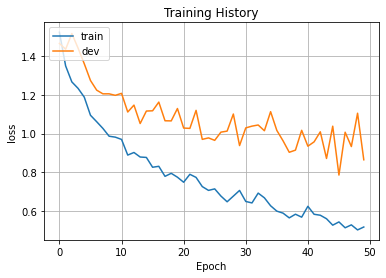

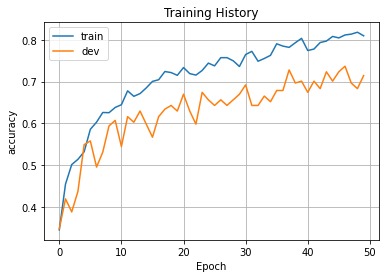

In [ ]:
""" Training History """

val_loss, val_acc = model.evaluate(val_generator, steps=step_size_val)
print("validation_loss, validation_accuracy = ", val_loss, val_acc)

keys = history.history.keys()


def show_train_history(hisData,train,test): 
    plt.plot(hisData.history[train])
    plt.plot(hisData.history[test])
    plt.title('Training History')
    plt.ylabel(train)
    plt.xlabel('Epoch')
    plt.legend(['train', 'dev'], loc='upper left')
    plt.grid()
    plt.show()

show_train_history(history, 'loss', 'val_loss')
show_train_history(history, 'accuracy', 'val_accuracy')



In [ ]:
""" Evaluate Model """

step_size_test = test_generator.n//test_generator.batch_size
test_loss, test_acc = model.evaluate(test_generator, steps=step_size_test)
print("test_loss, test_accuracy = ", test_loss, test_acc)


import numpy as np
from tabulate import tabulate

train_acc = history.history['accuracy'][-1]

m = np.array([["Accuracy", train_acc, val_acc, test_acc], ["Error", 1-train_acc, 1-val_acc, 1-test_acc]])
headers = ["", "Training", "Validation", "Test"]
table = tabulate(m, headers, tablefmt="fancy_grid")
print(table)

print("Variance =",  train_acc - val_acc  )

7/7 [==============================] - 2s 229ms/step - loss: 0.9033 - accuracy: 0.7054
test_loss, test_accuracy =  0.9032513499259949 0.7053571343421936
╒══════════╤════════════╤══════════════╤══════════╕
│          │   Training │   Validation │     Test │
╞══════════╪════════════╪══════════════╪══════════╡
│ Accuracy │   0.809237 │     0.709821 │ 0.705357 │
├──────────┼────────────┼──────────────┼──────────┤
│ Error    │   0.190763 │     0.290179 │ 0.294643 │
╘══════════╧════════════╧══════════════╧══════════╛
Variance = 0.09941554069519043


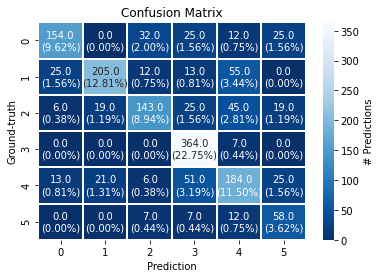

In [ ]:
""" Confusion Matrix """
from sklearn.metrics import confusion_matrix
import seaborn as sn
import numpy as np
import pandas as pd

test_count = 50
test = (next(test_generator) for _ in range(test_count))
# print(test)
cm = np.zeros((6,6))
for item in test:
  cm += confusion_matrix(
      np.argmax(item[1], axis=1),  # ground-truths
      np.argmax(model.predict(item[0]), axis=1), # predictions
      labels = range(6),
  )
# print(cm)


df_cm = pd.DataFrame(cm)
annotations = [ 
    [ "{}\n({:.2f}%)".format(value, value/(test_count*batch_size)*100) for value in row ] 
    for row in cm 
]
sn.heatmap(df_cm, 
           annot=annotations, fmt='',
           cmap="Blues_r", cbar_kws={'label': '# Predictions'},
           linecolor='w', linewidths=1,)


plt.title("Confusion Matrix")
plt.xlabel("Prediction")
plt.ylabel("Ground-truth")
plt.show()